# Prediction of Student Visa!



## Pre_processing

In this notebook we will perform the following functions:
* Import Data
* Add Ranking of Universities
** importing ranking database and cleaning it
** creating a search_and_replace function
** applying search_and_replace function to find the rankings of our training_data universities
** add columns 'Matched_University' and 'Rank' in the training_data
* Dropping Extra Columns
* Handle Missing Values

In [368]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests

First, we read the csv of the training data from the drive and then organize

In [369]:
df1 = pd.read_csv(r"data\training_data_new.csv")
df2 = pd.read_csv(r"data\training_data_visa.csv")
training_data = pd.concat([df1, df2], ignore_index=True)

### Dropping duplicates
training_data.drop_duplicates(inplace=True)

print(training_data.shape)
training_data.head()

(673, 10)


,Unnamed: 0,Id,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result
0,0,NaN,Criminal Justice,NaN,Western Michigan University,Uncle,NaN,Uncle,Second,Refused
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Second (Refusal Category),NaN
2,2,NaN,NaN,NaN,DePaul University,Father,Yes,NaN,Refused,NaN
3,3,NaN,PhD in Physics,PhD,Purdue University,NaN,Fully funded,No,First,Refused
4,4,NaN,Cyber Security,Masters,UD,Uncle,NaN,Uncle,First,Refused


In [370]:
training_data.drop(['Unnamed: 0', "Id"], axis=1, inplace=True)
training_data['Id'] = training_data.index

We have names of the universities. We can get the ranking of the university from internet and add it as a feature. An excel file was downloaded from the qs.com website which contains the university names and rankings.
Now, our job is to get the ranking of each university in our training data list and add a university ranking column in our dataset.

In [371]:
### import the ranking database ###

uni_data_dw = pd.read_csv(r"C:\Users\aseem\Jupyter_Notebook\Visa Prediction Model\National Universities Rankings.csv", encoding='ANSI')

In [372]:
### Create a data with only university name and its rank ###

unis = uni_data_dw['Name']
ranks = uni_data_dw['Rank']

uni_ranks = pd.DataFrame({'University': unis, 'Rank': ranks})

#### University Ranking Search Engine

In [373]:
### Creating a Search_and_Replace function

from fuzzywuzzy import fuzz
def search_list(query, my_df, search_col_name, result_col_name):
    
    
    # Define the threshold for the minimum score
    threshold = 60

    # Create an empty dictionary to store the results
    results_dict = {}

    # Loop through each string in the list
    for string in my_df[search_col_name]:
        # Calculate the Levenshtein distance between the search term and the current string
        score = fuzz.token_sort_ratio(query, string)

        # If the score is above the threshold, add the string and score to the dictionary
        if score >= threshold:
            results_dict[string] = score

    # Sort the dictionary by score, in descending order
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=True)
    
    if len(sorted_results) == 0:
        ## In case searc result is not found, specficy the output here
        ### print("Nothing found")
        result = "N/A"
        query_final = "N/A"
        
    else:
        # Search the index first element of sorted results through search col of my_df
        query_final = sorted_results[0][0]
        index = my_df[my_df[search_col_name].str.contains(query_final)].index

        # Check if the index exists before returning the result
        if not index.empty:
            result = my_df[result_col_name][index[0]]
        else:
            result = "N/A"

    return sorted_results, result, query_final

In [374]:
### test implementation of above function ###
uni_rank, rank, query = search_list('cincinnati university', uni_ranks, 'University', 'Rank')
print(f"The matched university and rank for name 'cincinnati university'  is {query, rank}")

The matched university and rank for name 'cincinnati university'  is ('University of Cincinnati', 142)


To search the university names from the ranking csv, it requires to have 'university' in the university name for the search function to pick up the uiversity name.

In [375]:
### Adding "University" to the university name if institute or university is not found ###

upd_uni = []
for university in training_data['University']:
    if isinstance(university, str):
        if not any("university" in word or "institute" in word or "college" in word for word in university.lower().split()):
            upd_uni.append(university + " University")
        else:
            upd_uni.append(university)
    else:
        upd_uni.append("N/A")

training_data['University'] = upd_uni

In [376]:
training_data.head(5)

,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result,Id
0,Criminal Justice,NaN,Western Michigan University,Uncle,NaN,Uncle,Second,Refused,0
1,NaN,NaN,N/A,NaN,NaN,NaN,Second (Refusal Category),NaN,1
2,NaN,NaN,DePaul University,Father,Yes,NaN,Refused,NaN,2
3,PhD in Physics,PhD,Purdue University,NaN,Fully funded,No,First,Refused,3
4,Cyber Security,Masters,UD University,Uncle,NaN,Uncle,First,Refused,4


Now we can see "Harvard University" instead of "Harvard".

In [377]:
### Search for the university name in the ranking database ###

found_ranks = []
found_uni_names = []
for university in training_data['University']:
    uni_rank, rank, query = search_list(university, uni_ranks, 'University', 'Rank')
    found_ranks.append(rank)
    found_uni_names.append(query)

In [378]:
# add the new column 'rank' to the dataframe
training_data = training_data.assign(Matched_University=found_uni_names, Rank = found_ranks)
training_data.head(5)

,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result,Id,Matched_University,Rank
0,Criminal Justice,NaN,Western Michigan University,Uncle,NaN,Uncle,Second,Refused,0,Western Michigan University,199
1,NaN,NaN,N/A,NaN,NaN,NaN,Second (Refusal Category),NaN,1,N/A,N/A
2,NaN,NaN,DePaul University,Father,Yes,NaN,Refused,NaN,2,DePaul University,126
3,PhD in Physics,PhD,Purdue University,NaN,Fully funded,No,First,Refused,3,Purdue University,60
4,Cyber Security,Masters,UD University,Uncle,NaN,Uncle,First,Refused,4,UD University,112


### Handle Missing Values

In [379]:
training_data.replace("N/A", np.nan, inplace = True)

#  Identify missing values
missing_values = training_data.isnull().sum()
print(missing_values)

# Replace missing values
training_data.dropna(subset=['Visa Result'], inplace=True)
training_data['Rank'].fillna(1000, inplace=True)
training_data['University'].fillna(("Unknown"), inplace=True)
training_data['Matched_University'].fillna(("Unknown"), inplace=True)
training_data['Scholarship'].fillna(("No"), inplace=True)

# For categorical columns, fill with mode
training_data.fillna(training_data.mode().iloc[0], inplace=True)

Program               153
Degree Level          251
University            199
Sponsor               220
Scholarship           496
Relatives             463
Visa Attempt           39
Visa Result            61
Id                      0
Matched_University    208
Rank                  208
dtype: int64


### Standardizing the Data

In [380]:
### function to standardize the dataframe column
def standardize_strings(train_df ,search_list, replace_list, column, replacement):
    # create a sample dataframe
    df = train_df.copy()

    for i in range(len(search_list)):
        if len(search_list) != len(replace_list):
            print("The length of search and replace lists are not equal!!!")
            continue
        search_string = search_list[i].lower()
        replace_string = replace_list[i]
        df[column] = df[column].astype(str)
        # loop hrough the column and replace the string if it's found
        for index, row in df.iterrows():
            if search_string in row[column].lower():
                df.at[index, column] = replace_string
    
    not_found_list = df[~df[column].isin(list(map(str, replace_list)))][column].unique()
    df[column] = df[column].apply(lambda x: replacement if x in not_found_list else x)


    if len(not_found_list) > 0:
        print(f"The following values were not found in the 'replace_list': {not_found_list}")
    else:
        print(f"All values in {column} are standardized.")
        
            
    return df

In [381]:
### Standardizing Degree Level
column = 'Degree Level'
degree_search_list = ['college', 'ms', 'master', 'grad', 'bachelor', 'bacca', 'Phd', 'bs', 'doctor']
degree_replace_list = [1, 3, 3, 3, 2, 2, 4, 2, 4]

train_data_std_1 = standardize_strings(training_data, degree_search_list, degree_replace_list, column, '3')

The following values were not found in the 'replace_list': ['Transfer Student' 'Diploma' 'Associates' 4 'N/A (not mentioned)'
 'F-1 Univsersity']


In [382]:
### Standardizing Sponsor

column = 'Sponsor'
sponsor_search_list = ['father', 'mother', 'parent', 'self', 'assistantship', 'fund', 'employer', 'supervisor', 'research', 'professor', 'loan']
sponsor_replace_list = ['Family', 'Family', 'Family', 'Self', 'University', 'University', 'Employer', 'University', 'University', 'University', 'Loan']
train_data_std_2 = standardize_strings(train_data_std_1, sponsor_search_list, sponsor_replace_list, column, 'Other')

The following values were not found in the 'replace_list': ['Uncle' 'Brother' 'Husband' 'SAME' 'Aunt' 'Landlord/Business Owner'
 'Told' 'Partner' 'Uncle and Aunt' 'XYZ' 'Cousin' 'Applicant'
 'Global Graduate  Program' 'Spouse' 'HEC' 'Yes' 'Xyz' 'Brother-in-law']


In [383]:
### Standardizing Scholarship

column = 'Scholarship'
sponsor_search_list = ['assistantship', '$', '%', 'No', 'k', 'USD', 'Yes', 'scholarship', 'fund', 'prof', 'merit']
sponsor_replace_list = ['Assistantship', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes','Yes','Assistantship', 'Assistantship', 'Yes']
train_data_std_3 = standardize_strings(train_data_std_2, sponsor_search_list, sponsor_replace_list, column, 'No')


The following values were not found in the 'replace_list': ['Full' 'Out of state waiver' 'Partial' 'Full-tuition wavier and GRA'
 'Automatic' '80' 'Financial Aid']


In [384]:
### Standardizing Scholarship

column = 'Program'
program_search_list = ['engineering', 'cs', 'Computer', 'information', 'it', 'Business', 'Health', 'Management', 'Science', 'Finance', 'MBA']
program_replace_list = ['Engineering', 'CS', 'CS', 'CS', 'CS','Business', 'Health', 'Management', 'Science', 'Business', 'Business']
train_data_std_4 = standardize_strings(train_data_std_3, program_search_list, program_replace_list, column, 'Other')


The following values were not found in the 'replace_list': ['Criminal Justice' 'Marketing' 'Biotechnology' 'IELI' 'Biology'
 'Public Administration' 'Bachelor' 'Food Technology and Processing'
 'Flight Training' 'Big Data Analysts' 'ECE' 'Environmental Studies'
 'Transportation' 'PhD' 'Nursing'
 'Cinematography and Film/Video Production' 'BBA' 'Undisclosed' 'Masters'
 'Energy Systems' "Master's" 'Agriculture' 'Differential Equations'
 'Electrical' 'MSBA' 'Professional Accountancy' 'Observership'
 'English Course (Pathway)' 'MS in Java' 'Fashion Design and Merchandise'
 'CIS' 'Film' 'M.A Higher Education in Academic Advising' 'Chemistry'
 'Chemistry PhD' 'Training Session' 'Academic Intensive English'
 'Doctorate' 'Conference' 'Cinematography and Film Production' 'SCM'
 'F2 Visa' 'MS BA' 'Career Counseling' 'J-1 Visa' 'Bachelors' 'J1'
 'Undergrad' 'Peace and Conflict Studies' 'MPA' 'Public Affairs'
 'Criminal Justice and Law Enforcement Administration' 'F2' 'Master'
 'Postdoctoral Resea

In [385]:
### Standardizing Visa Result

column = 'Visa Result'
visa_search_list = ['221', 'processing', 'pending', 'N/A', 'Approved', 'Accepted', 'Refused', 'Rejected']
visa_replace_list = [1, 1, 1, 0, 1, 1, 0, 0]
train_data_std_5 = standardize_strings(train_data_std_4, visa_search_list, visa_replace_list, column, '0')

The following values were not found in the 'replace_list': [0]


In [386]:
### Standardizing Relatives

column = 'Relatives'
relatives_search_list = ['Husband', 'Spouse', 'Brother', 'Sister', 'Father', 'Uncle', 'Mother', 'Aunt' ]
relatives_replace_list = ['Spouse', 'Spouse', 'Brother', 'Sister', 'Parents', 'No', 'Parents', 'No']
train_data_std_6 = standardize_strings(train_data_std_5, relatives_search_list, relatives_replace_list, column, 'No')


The following values were not found in the 'replace_list': ['N/A s' 'None' 'Yes' 'No s' 'No relatives in US' 'No relatives in USA'
 'Cousin' 'No other relative' 'Friend' 'No relatives in US s'
 'Parents and younger sibling' 'Family in Saudi Arabia' 'F2'
 'Extended family' 'Wife' 'Engaged to US Citizen']


In [387]:
### Standardizing Visa Attempt

column = 'Visa Attempt'
attempt_search_list = ['st', 'nd', 'rd', 'th']
attempt_replace_list = [1, 2, 3, 4]
train_data_std_7 = standardize_strings(train_data_std_6, attempt_search_list, attempt_replace_list, column, '2')

The following values were not found in the 'replace_list': ['Previous Visa Refusal' 'Previous Refusal' 4 'Renewal'
 'N/A (not mentioned)']


In [388]:
### Specifying the red_list universities ###

red_list = ['Wichita State University, Indiana Institute of...', 'Webster University', 'Adelphi University' , 'UD University' , 'Troy University', 'Saint Louis University', 'Mercer University', 'Full Sail University', 'Gannon University', 'Maharishi International University', 'University of New Haven', 'Westcliff University', 'St. cloud state university', 'Bay Atlantic University', 'Salem University', 'UD University', 'Dayton Unviersity', 'Cleveland State University']

### Creating a column for red_list universities ###
### if university is in red_list, then 1, else 0 ###
train_data_std_7['Red List'] = np.where(train_data_std_7['University'].isin(red_list), 1, 0)

### Filtering Unknown Universities

df = train_data_std_7[train_data_std_7['Matched_University'] != 'Unknown']

# Binning Rank #
### We will bin the rank into 4 categories: 1-100, 101-200, 201-500, 501- ###

df['Rank'] = pd.cut(df['Rank'], bins=[0, 100, 200, 500, 2000], labels=[1, 2, 3, 4])


C:\Users\aseem\AppData\Local\Temp\ipykernel_13032\2005043375.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rank'] = pd.cut(df['Rank'], bins=[0, 100, 200, 500, 2000], labels=[1, 2, 3, 4])


In [389]:
clean_training_data = df.loc[:, ['Program', 'Degree Level', 'Scholarship','Sponsor', 'Relatives', 'Rank', 'Red List', 'Visa Attempt', 'Visa Result']]
clean_target_data = df[['Visa Result']].astype(int)
print(clean_training_data.shape)
(clean_training_data.head())

(431, 9)


,Program,Degree Level,Scholarship,Sponsor,Relatives,Rank,Red List,Visa Attempt,Visa Result
0,Other,3,No,Other,No,2,0,2,0
3,CS,4,Assistantship,Family,No,1,0,1,0
4,CS,3,No,Other,No,2,1,1,0
5,CS,3,No,Family,Brother,1,0,2,0
6,Business,3,No,Family,Parents,2,0,3,0


## Exploratory Data Analysis

In [390]:
### Defining Colors
red = (231/256, 99/256, 118/256)
green = (166/256, 211/256, 160/256)
blue = (107/256, 127/256, 215/256)

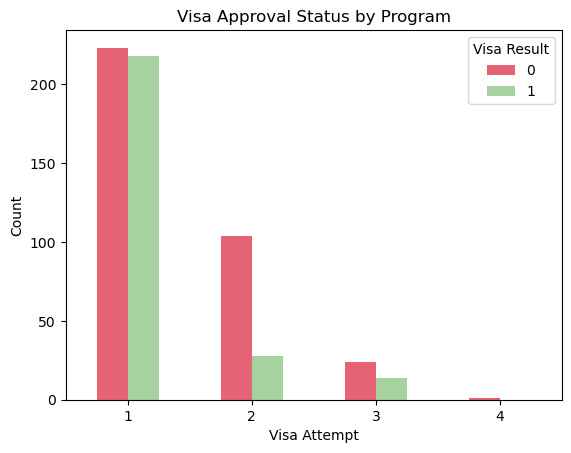

In [391]:
# Group the data by category and visa result, and calculate the counts
counts = train_data_std_7.groupby('Visa Attempt')['Visa Result'].value_counts().unstack()

# Create bar plot
counts.plot.bar(rot=0, color= [red,green])

# Add labels and title
plt.xlabel("Visa Attempt")
plt.ylabel("Count")
plt.title("Visa Approval Status by Program")

# Show the chart
plt.show()

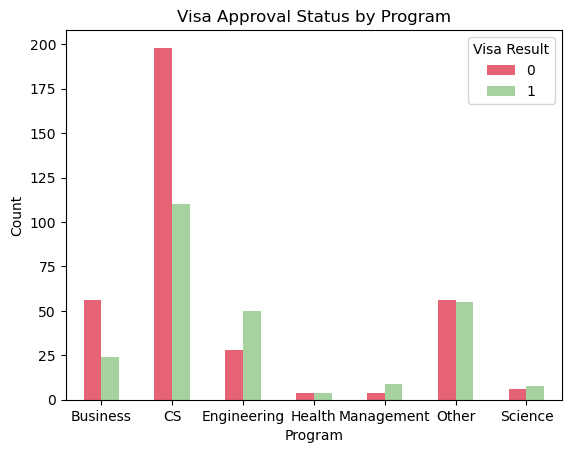

In [392]:
# Group the data by category and visa result, and calculate the counts
counts = train_data_std_7.groupby('Program')['Visa Result'].value_counts().unstack()

# Create bar plot
counts.plot.bar(rot=0, color= [red,green])

# Add labels and title
plt.xlabel("Program")
plt.ylabel("Count")
plt.title("Visa Approval Status by Program")

# Show the chart
plt.show()

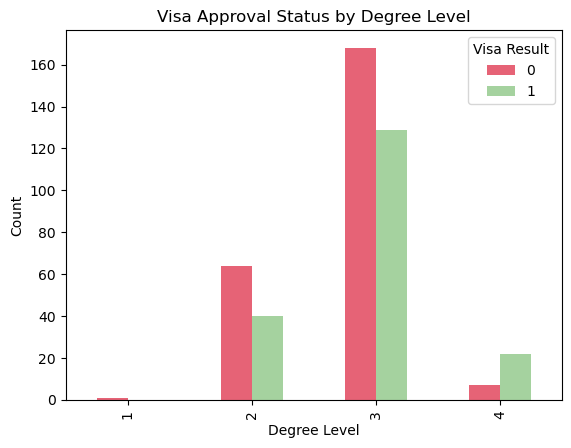

In [393]:
# Group the data by category and visa result, and calculate the counts
counts = clean_training_data.groupby('Degree Level')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])


# Add labels and title
plt.xlabel("Degree Level")
plt.ylabel("Count")
plt.title("Visa Approval Status by Degree Level")

# Show the chart
plt.show()

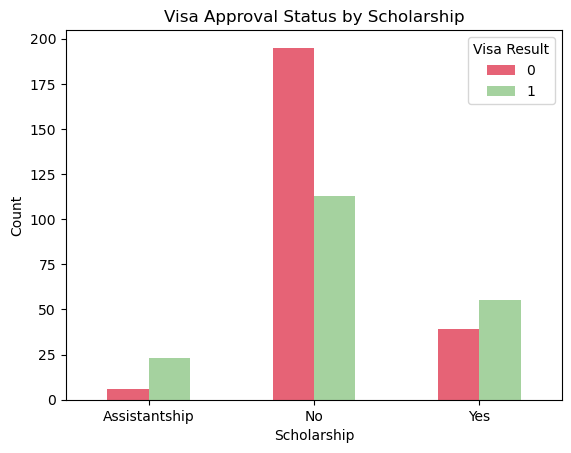

In [394]:
# Group the data by category and visa result, and calculate the counts
counts = clean_training_data.groupby('Scholarship')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])

# Add labels and title
plt.xlabel("Scholarship")
plt.ylabel("Count")
plt.title("Visa Approval Status by Scholarship")
plt.xticks(rotation=0)
# Show the chart
plt.show()


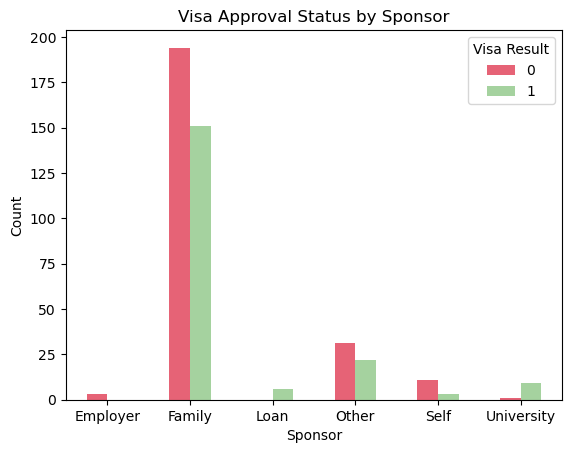

In [395]:
# Group the data by category and visa result, and calculate the counts
counts = clean_training_data.groupby('Sponsor')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])

# Add labels and title
plt.xlabel("Sponsor")
plt.ylabel("Count")
plt.title("Visa Approval Status by Sponsor")
plt.xticks(rotation=0)
# Show the chart
plt.show()

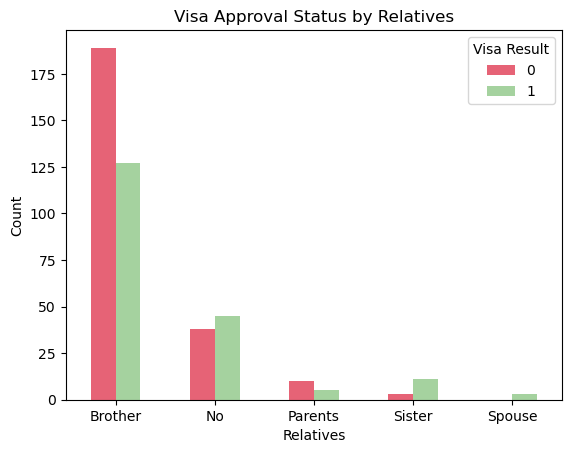

In [396]:
# Group the data by category and visa result, and calculate the counts
counts = clean_training_data.groupby('Relatives')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])

# Add labels and title
plt.xlabel("Relatives")
plt.ylabel("Count")
plt.title("Visa Approval Status by Relatives")
plt.xticks(rotation=0)
# Show the chart
plt.show()

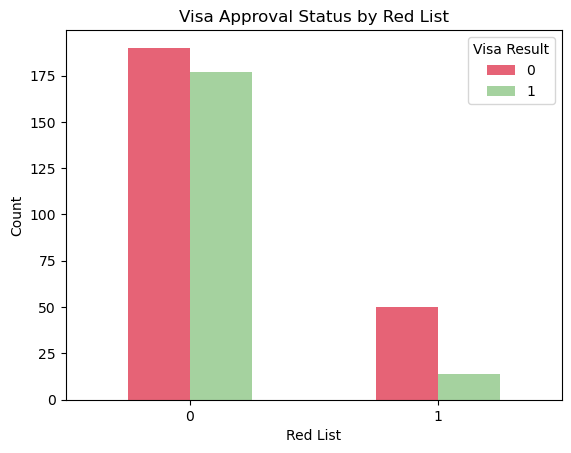

In [397]:
# Group the data by category and visa result, and calculate the counts
counts = clean_training_data.groupby('Red List')['Visa Result'].value_counts().unstack()

# Create bar plot with custom colors
counts.plot.bar(color=[red, green])

# Add labels and title
plt.xlabel("Red List")
plt.ylabel("Count")
plt.title("Visa Approval Status by Red List")
plt.xticks(rotation=0)
# Show the chart
plt.show()

In [398]:
### Breaking Down Data into Numeric and Categorical Features ###

numeric_columns = ['Visa Attempt', 'Degree Level', 'Rank', 'Red List']
cat_columns = ['Program',   'Scholarship', 'Relatives']

### Applying One-Hot Transformation to Categorical Features ###

numeric_train = clean_training_data.loc[:, numeric_columns]
oh_cat_train =pd.get_dummies(clean_training_data[cat_columns], columns=cat_columns).astype(int)
all_features_train = pd.concat([numeric_train, oh_cat_train], axis=1).astype(int)

# Machine Learning Model

In [399]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(all_features_train, clean_target_data, test_size = 0.3, random_state=27)

In [400]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# fix the randomization
np.random.seed(32)
tf.random.set_seed(32)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to TensorFlow tensors
X_train_scaled = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_scaled = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_scaled = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
y_test_scaled = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [401]:
lamda = 0.001

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamda), input_dim=X_train.shape[1]),
    tf.keras.layers.Dense(20, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamda)),
    tf.keras.layers.Dense(50, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamda)),
    tf.keras.layers.Dense(20, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamda)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=80, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), verbose=0)

# Make predictions on the training set
y_pred_train = model.predict(X_train_scaled)


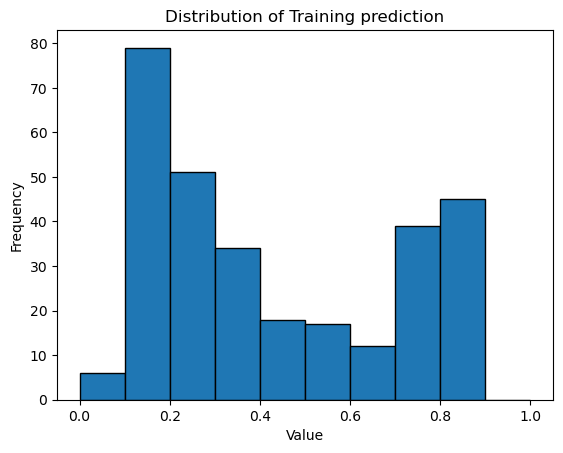

In [402]:
# Define the bin edges.
bins = np.arange(0, 1.1, 0.1)

# Plot a histogram.
plt.hist(y_pred_train, bins=bins, edgecolor='black')

# Set the labels and title.
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Training prediction')

# Show the plot.
plt.show()

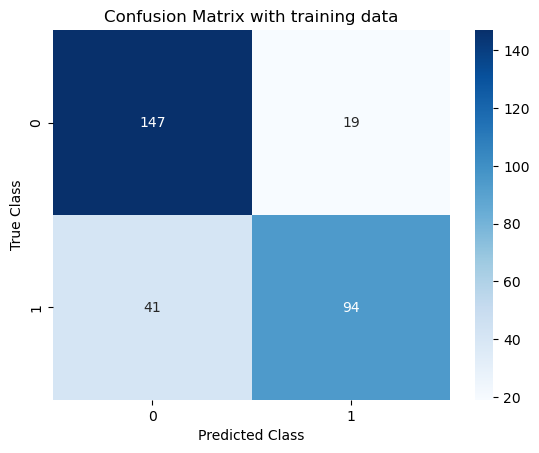

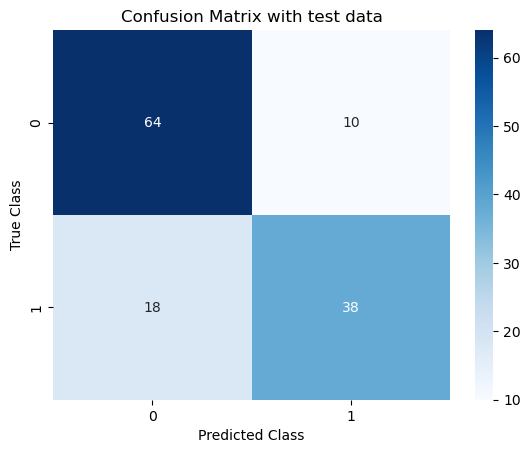

The accuracy with training data is 0.8006644518272426
The accuracy with test data is 0.7846153846153846
Precision: 0.7916666666666666
Recall: 0.6785714285714286
F1 Score: 0.7307692307692307


In [404]:
y_pred_train_bin = y_pred_train > .5
conf_matrix_train = confusion_matrix(y_train, y_pred_train_bin)
accuracy_train = accuracy_score(y_train, y_pred_train_bin)

y_pred_test = model.predict(X_test_scaled)
y_pred_test_bin = y_pred_test > .5
conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
accuracy_test = accuracy_score(y_test, y_pred_test_bin)

sns.heatmap(conf_matrix_train, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with training data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

sns.heatmap(conf_matrix_test, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with test data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print(f"The accuracy with training data is {accuracy_train}")
print(f"The accuracy with test data is {accuracy_test}")

### calculating the precision, recall and f1 score ###
precision_train = precision_score(y_train, y_pred_train_bin)
recall_train = recall_score(y_train, y_pred_train_bin)
f1_train = f1_score(y_train, y_pred_train_bin)

precision_test = precision_score(y_test, y_pred_test_bin)
recall_test = recall_score(y_test, y_pred_test_bin)
f1_test = f1_score(y_test, y_pred_test_bin)

### printing the precision, recall and f1 score for test set
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


### Random Forest

C:\Users\aseem\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


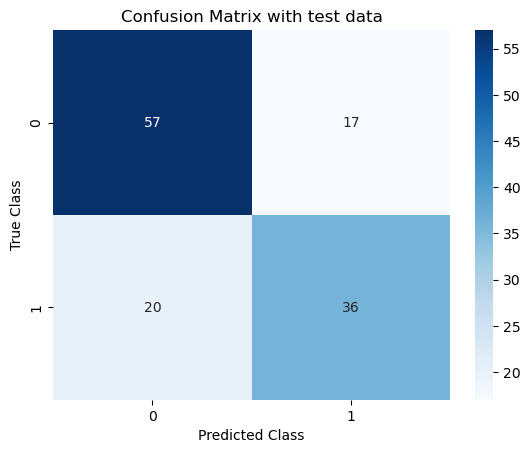

Accuracy: 0.7153846153846154
Precision: 0.6792452830188679
Recall: 0.6428571428571429
F1 Score: 0.6605504587155964


In [407]:
### applying random forest classifier ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Create the model with 100 trees
abc = AdaBoostClassifier(n_estimators=500, random_state=27, learning_rate=0.1)

# Train the model on training data
abc.fit(X_train, y_train)

# Use the forest's predict method on the test data
y_pred = abc.predict(X_test)

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with test data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### Callucating precison, recall and f1 score ###
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

### Results

Thus, we conclude that neural network is outperforming the decision trees in this case. Here are some further findings:
1. There is only limited information available in our features. Thus, many same features predict different output. The reason is that our features do not contain that extra piece of information to predict the correct outcome. 
2. The analysis tells that some information is hidden in the actual profile, like past university and course alignment etc. This is not possible to gather the data for all these and train a model on these.
3. We will use the eights of neural networks and use the probability to tell how strong the visa chances for a particular candidate are.